# Criminals in Seattle Don't Like to Stay Up Late

Actually, that might not be something we can support with the data at hand. We can, however, say quite confidently that during the summer of 2014, the number of incidents reported to police dropped drastically after midnight. Based on this data, relatively few crimes occur that late at night, despite a [popular belief that nothing good happens after 2 A.M.](https://en.wikipedia.org/wiki/Nothing_Good_Happens_After_2_A.M.)

To support this claim, let's start from the beginning and build up to a chart that will make this fact abundantly clear.

The Data
--------

The data comes in the form of a CSV file, so let's load it up in [Pandas](http://pandas.pydata.org/pandas-docs/stable/) and see what we've got.

In [1]:
import pandas as pd
seattle_data = pd.read_csv('data/seattle_incidents_summer_2014.csv')

/Users/hank/dev/.virtualenvs/datasci_assignment_six/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Well, the first thing I noticed about it is that type inference is failing on column 9. Let's see what it's supposed to be.

In [2]:
seattle_data.columns

Index(['RMS CDW ID', 'General Offense Number', 'Offense Code',
       'Offense Code Extension', 'Offense Type', 'Summary Offense Code',
       'Summarized Offense Description', 'Date Reported',
       'Occurred Date or Date Range Start', 'Occurred Date Range End',
       'Hundred Block Location', 'District/Sector', 'Zone/Beat',
       'Census Tract 2000', 'Longitude', 'Latitude', 'Location', 'Month',
       'Year'],
      dtype='object')

Apparently, that's `Occurred Date Range End`. Let's take a peak and see what's in that column.

In [3]:
seattle_data['Occurred Date Range End'].head()

0    06/28/2015 10:31:00 AM
1    06/24/2015 11:09:00 AM
2                       NaN
3                       NaN
4    11/01/2014 12:00:00 PM
Name: Occurred Date Range End, dtype: object

OK, it seems like the problem is some `NaN` entries. Luckily, Pandas let's us specify different strings that mean N/A, so we'll read the file again and tell it that `NaN` is one such value.

While we're at it, let's tell Pandas to parse all these different timestamps. We'll leave it to Pandas to figure out the format, if possible.

In [4]:
seattle_data = pd.read_csv(
    'data/seattle_incidents_summer_2014.csv',  # The data file.
    na_values=['NaN'],  # 'NaN' means it's a missing value.
    parse_dates=[7,8,9],  # Columns 7-9 contain timestamps; try to parse them as such.
    infer_datetime_format=True  # I don't want to comb over all that data to figure out a format; let Pandas try.
)

No warnings or errors this time, so I suspect our changes worked. Let's go ahead and peek at the data to see how it looks.

In [5]:
seattle_data.head()

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,2015-06-28 10:31:00,2014-06-28 10:31:00,2015-06-28 10:31:00,6XX BLOCK OF NW 74 ST,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,2015-06-24 11:09:00,2014-06-01 00:00:00,2015-06-24 11:09:00,23XX BLOCK OF 43 AV E,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014
2,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,2015-06-22 09:22:00,2014-08-31 09:00:00,NaT,81XX BLOCK OF 11 AV SW,F,F3,11300.5013,-122.349312,47.529232,"(47.529232299, -122.349312181)",8,2014
3,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,2015-06-21 15:52:00,2014-06-20 13:38:00,NaT,6XX BLOCK OF PINE ST,M,M2,8200.1002,-122.334818,47.612368,"(47.612368448, -122.334817763)",6,2014
4,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,2015-06-20 11:59:00,2014-06-01 11:59:00,2014-11-01 12:00:00,77XX BLOCK OF SUNNYSIDE AV N,J,J3,2700.2015,-122.329379,47.685960,"(47.685959879, -122.329378505)",6,2014


That seems reasonable, so let's move on to the next step: visualizing the data and identifying patterns.

To see how crime levels vary during the course of a day, we'll plot the total number of incidents against the hour in which they occurred. The first issue we see is the `Occurred Date or Date Range Start` column is at the wrong level of granularity to answer this question: it is actually a full date-time timestamp. We'll need to extract just the hour portion into a new column—call it `hour_of_incident`. We'll also add an `identity` column, which will just be a bunch of `1`s that we sum up later.

In [6]:
# Set up our ``DataFrame`` in dplython to make it easier to manipulate.
from dplython import DplyFrame, X, arrange, group_by, mutate, select, sift, summarize
dply_seattle = DplyFrame(seattle_data)

# Tell Jupyter we want to render these plots inline in the notebook, in the style of ggplot.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import datetime

def get_hour(ts):
    return ts.hour

with_hour = (dply_seattle
    >> mutate(
        hour_of_incident = X['Occurred Date or Date Range Start'].apply(get_hour),
        identity = 1
    )
)

Now we have the basic info we need for plotting the data against the hour of the day. Rather than a raw "incident" count for each hour, I think it would be useful to see the different types of offenses broken out separately. A line chart would be a fairly obvious choice here, but I still want to see the total number of offenses per hour, so let's use a [stacked area plot](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-area-plot) instead, which is happily baked right into the `DataFrame`.

This visualization expects to find the different categories to plot as columns, so we'll need to reshape our data. Once again, the `DataFrame` has what we need: the [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/reshaping.html#pivot-tables) function.

In [7]:
hour_and_offense_counts = with_hour[["hour_of_incident", "Offense Type", "identity"]].pivot_table(
    index="hour_of_incident",  # We're going to use the hour of the offense as the index.
    columns="Offense Type",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each hour.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
hour_and_offense_counts.columns

Index(['ANIMAL-BITE', 'ANIMAL-CRUELTY', 'ANIMAL-OTH', 'ASSLT-AGG-BODYFORCE',
       'ASSLT-AGG-GUN', 'ASSLT-AGG-POLICE-BODYFORCE', 'ASSLT-AGG-POLICE-GUN',
       'ASSLT-AGG-POLICE-WEAPON', 'ASSLT-AGG-WEAPON', 'ASSLT-NONAGG',
       ...
       'WARRANT-FUGITIVE', 'WARRARR-FELONY', 'WARRARR-MISDEMEANOR',
       'WEAPON-CONCEALED', 'WEAPON-DISCHARGE', 'WEAPON-POSSESSION',
       'WEAPON-SELLING', 'WEAPON-SURRENDER-EXCLUDING FIR',
       'WEAPON-UNLAWFUL USE', '[INC - CASE DC USE ONLY]'],
      dtype='object', name='Offense Type', length=147)

Hmm… that's a **lot** of columns. I think we're going to need to pare down our categories a bit. This is going to be a *very* rough cut at this, because doing a good job would likely require a detailed analysis of the coding system used to build the source data, and I don't have that information. 

From a cursory glance at the data, I can see that there are multiple `Offense Type` values for assaults, weapons charges, etc., so let's try to consolidate similar types of offenses. Each of those "super categories" appears to be broken down using the following scheme: TOP-SUB1-SUB2, so we can get the top-level categories by doing a simple split.

In [8]:
def extract_top_level_type(x):
    return x.split('-')[0]

full_partly_consolidated_with_hour = (with_hour
    >> mutate(
        consolidated_offense = X['Offense Type'].apply(extract_top_level_type)
    )
)

OK, let's see how many categories we're looking at after the consolidation.

In [9]:
full_partly_consolidated_with_hour.consolidated_offense.nunique()

51

51 is still too many, so let's try something a bit more… extensive.

According to [this LegalMatch article](http://www.legalmatch.com/law-library/article/what-are-the-different-types-of-crimes.html), crimes are generally divided into the following categories:

<dl>
  <dt>Personal Crimes</dt><dd>crimes that result in physical or mental harm to another person, e.g., assault</dd>
  <dt>Property Crimes</dt><dd>crimes that do not necessarily involve harm to another person, instead involving an interference with another person’s right to use or enjoy their property, e.g., burglary</dd>
  <dt>Inchoate Crimes</dt><dd>crimes that were begun, but not completed, e.g., solicitation. This requires that a person take a substantial step to complete a crime, as opposed to just “intend” to commit a crime.</dd>
  <dt>Statutory Crimes</dt><dd>violations of specific state or federal statutes, and can involve either property offenses or personal offenses, e.g., DUI.</dd>
</dl>

I have manually mapped each of the `Offense Type` entries back to these 4 categories, although based on my rudimentary undertanding, none of them actually qualified as "Inchoate", and some would have fit under either "Personal" or "Property", e.g, all of the `ROBBERY-…` entries.

If something could be construed as both a Statutory Crime and a more specific type of crime, such as Property, I classified it as the more specific type, because I felt that provided the most information.

In [10]:
_personal = set([
    'ASSLT-AGG-BODYFORCE', 'ASSLT-AGG-GUN', 'ASSLT-AGG-POLICE-BODYFORCE',
    'ASSLT-AGG-POLICE-GUN','ASSLT-AGG-POLICE-WEAPON', 'ASSLT-AGG-WEAPON',
    'ASSLT-NONAGG', 'ASSLT-NONAGG-POLICE', 'DISPUTE-OTH', 'ENDANGERMENT',
    'HARASSMENT', 'HOMICIDE-JUST-GUN', 'HOMICIDE-JUST-WEAPON',
    'HOMICIDE-PREMEDITATED-GUN', 'INJURY - ACCIDENTAL',
    'INJURY - OTHER', 'MALICIOUS HARASSMENT', 'ROBBERY-BANK-BODYFORCE',
    'ROBBERY-BANK-GUN', 'ROBBERY-BANK-WEAPON', 'ROBBERY-BUSINESS-BODYFORCE',
    'ROBBERY-BUSINESS-GUN', 'ROBBERY-BUSINESS-WEAPON', 'ROBBERY-RESIDENCE-BODYFORCE',
    'ROBBERY-RESIDENCE-GUN', 'ROBBERY-RESIDENCE-WEAPON', 'ROBBERY-STREET-BODYFORCE',
    'ROBBERY-STREET-GUN', 'ROBBERY-STREET-WEAPON', 'THREATS-KILL', 'THREATS-OTHER',
    'THREATS-WEAPON',
])
_property = set([
    'BURGLARY-FORCE-NONRES', 'BURGLARY-FORCE-RES', 'BURGLARY-NOFORCE-NONRES',
    'BURGLARY-NOFORCE-RES', 'BURGLARY-SECURE PARKING-NONRES', 'BURGLARY-SECURE PARKING-RES',
    'COUNTERFEIT', 'DISPUTE-CIVIL PROPERTY (AUTO)', 'DISPUTE-CIVIL PROPERTY (NON AU',
    'EMBEZZLE', 'FORGERY-CHECK', 'FORGERY-CREDIT CARD', 'FORGERY-OTH',
    'FRAUD-CHECK', 'FRAUD-COMPUTER', 'FRAUD-CREDIT CARD', 'FRAUD-IDENTITY THEFT',
    'FRAUD-OTHER', 'FRAUD-WIRE-ELECTRONIC', 'PROP RECOVERED-OTHER AGENCY',
    'PROPERTY DAMAGE - GRAFFITI', 'PROPERTY DAMAGE-NON RESIDENTIA', 'PROPERTY DAMAGE-RESIDENTIAL',
    'PROPERTY FOUND', 'PROPERTY LOST', 'PROPERTY LOST - POLICE EQUIPME',
    'PROPERTY STOLEN-POSSESS', 'PROPERTY STOLEN-SELL', 'PROPERTY STOLEN-TRAFFICKING',
    'RECKLESS BURNING', 'THEFT OF SERVICES', 'THEFT-AUTO PARTS', 'THEFT-AUTOACC',
    'THEFT-BICYCLE', 'THEFT-BOAT', 'THEFT-BUILDING', 'THEFT-CARPROWL', 'THEFT-COINOP',
    'THEFT-LICENSE PLATE', 'THEFT-MAIL', 'THEFT-OTH', 'THEFT-PKPOCKET', 'THEFT-PRSNATCH',
    'THEFT-SHOPLIFT', 'TRESPASS', 'VEH-RCVD-FOR OTHER AGENCY', 'VEH-THEFT-AUTO',
    'VEH-THEFT-MTRCYCLE', 'VEH-THEFT-OTHVEH', 'VEH-THEFT-TRAILER', 'VEH-THEFT-TRUCK',
])
_inchoate = set()
_statutory = set([
    'ANIMAL-BITE', 'ANIMAL-CRUELTY', 'ANIMAL-OTH', 'BIAS INCIDENT', 'DISORDERLY CONDUCT',
    'DISTURBANCE-NOISE', 'DISTURBANCE-OTH', 'DRIVE-BY', 'DUI-DRUGS', 'DUI-LIQUOR',
    'ELUDING-FELONY FLIGHT', 'ESCAPE', 'FALSE REPORT', 'FIREWORK-POSSESS', 'FIREWORK-USE',
    'ILLEGAL DUMPING', 'LIQUOR LAW VIOLATION', 'NARC-DRUG TRAFFIC LOITERING',
    'NARC-EQUIPMENT/PARAPHENALIA', 'NARC-FORGERY-PRESCRIPTION', 'NARC-FOUND-AMPHETAMINE',
    'NARC-FOUND-COCAINE', 'NARC-FOUND-HEROIN', 'NARC-FOUND-MARIJU', 'NARC-FOUND-METH',
    'NARC-FOUND-OPIUM', 'NARC-FOUND-OTHER', 'NARC-FOUND-SYNTHETIC', 'NARC-FRAUD-PRESCRIPTION',
    'NARC-POSSESS-AMPHETAMINE', 'NARC-POSSESS-COCAINE', 'NARC-POSSESS-HALLUCINOGEN',
    'NARC-POSSESS-HEROIN', 'NARC-POSSESS-MARIJU', 'NARC-POSSESS-METH', 'NARC-POSSESS-OTHER',
    'NARC-POSSESS-PILL/TABLET', 'NARC-PRODUCE-MARIJU', 'NARC-SELL-AMPHETAMINE',
    'NARC-SELL-COCAINE', 'NARC-SELL-HEROIN', 'NARC-SELL-MARIJU', 'NARC-SELL-METH',
    'NARC-SELL-SYNTHETIC', 'NARC-SMUGGLE-OTHER', 'OBSTRUCT', 'PORNOGRAPHY-OBSCENE MATERIAL',
    'PROSTITUTION', 'PROSTITUTION LOITERING', 'PROSTITUTION PATRONIZING', 'PROSTITUTION-ASSIST-PROMOTE',
    'TRAFFIC', 'URINATING/DEFECATING-IN PUBLIC', 'VIOL-COURT ORDER', 'WARRANT-FUGITIVE',
    'WARRARR-FELONY', 'WARRARR-MISDEMEANOR', 'WEAPON-CONCEALED', 'WEAPON-DISCHARGE',
    'WEAPON-POSSESSION', 'WEAPON-SELLING', 'WEAPON-SURRENDER-EXCLUDING FIR', 'WEAPON-UNLAWFUL USE',
    '[INC - CASE DC USE ONLY]'
])

def map_offense_type_to_category(ot):
    if ot in _personal:
        return "PERSONAL"
    if ot in _property:
        return "PROPERTY"
    if ot in _inchoate:
        return "INCHOATE"
    if ot in _statutory:
        return "STATUTORY"
    return None

full_consolidated_with_hour = (with_hour
    >> mutate(
        consolidated_offense = X['Offense Type'].apply(map_offense_type_to_category)
    )
)
consolidated_with_hour = (full_consolidated_with_hour
    >> select(X.hour_of_incident, X.consolidated_offense, X.identity)
)

OK, let's see how many categories we're looking at after *this* consolidation (it should be 3).

In [11]:
consolidated_with_hour.consolidated_offense.nunique()

3

3 is the answer we were looking for, so let's do an area plot now.

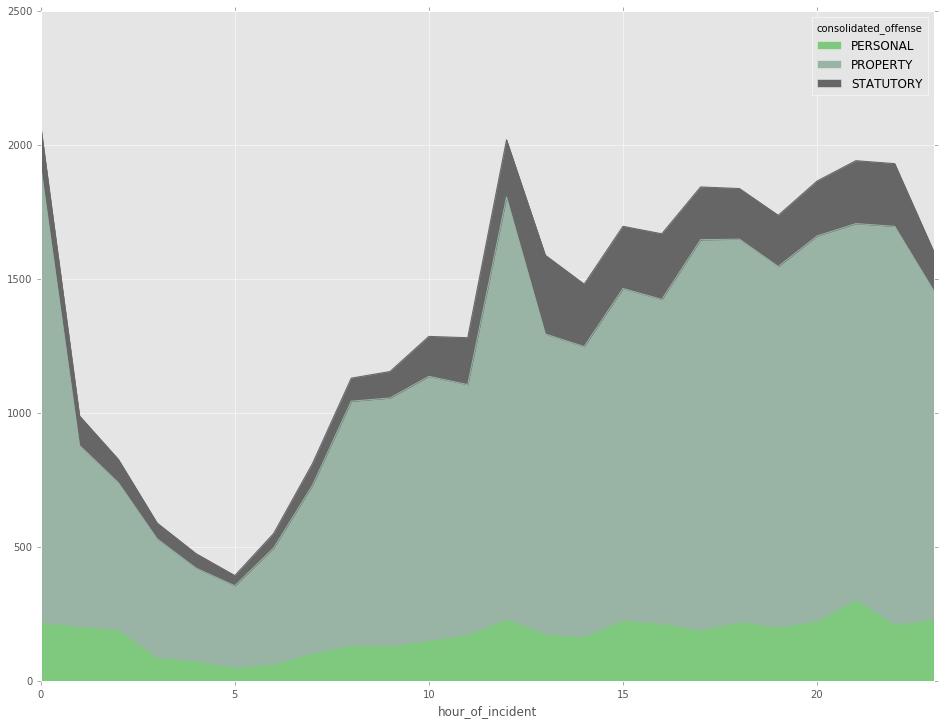

In [12]:
hour_and_offense_counts = consolidated_with_hour.pivot_table(
    index="hour_of_incident",  # We're going to use the date of the offense as the index.
    columns="consolidated_offense",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each date.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
hour_and_offense_counts.plot.area(figsize=(16,12), colormap='Accent')

It would appear that criminals have the same basic sleep patterns as society at large: there is a *significant* drop in the number of crimes committed once we get past midnight, bottoming out at 5 A.M. with approximately 400 reported incidents. By about 8 A.M., the number of incidents is back up to approximately 1 A.M. levels. To be fair, the criminals might not be sleeping, but they aren't committing crimes.

You might object that this dip could be explained by fewer people being awake to report crimes, and that could be true. We've attempted to account for that by specifically using `Occurred Date or Date Range Start`, and noting that `Date Reported` is a separate timestamp field.

As for the rest of the day, crime levels increase rapidly until noon, and then drop back down for a couple of hours; maybe criminals like to take naps, too, or perhaps they're just suffering food coma. Crime levels then rise unsteadily toward their midnight peak of over 2000. and then slowly rises throughout the afternoon/evening, with peak criminal activity coming in the midnight hour.

At all hours, property crimes are by far the most numerous type of crime.

#### Question 1.A) Which incidents are most common in the evening?

First, let's define "evening". The sources I found on the Internet largely agree it's the time between 6PM and night. Since the sun sets at approximately 9PM (or earlier) during the summer in Seattle, we will say that any incident that occurred during hours 18,19, or 20 qualify (that's 6:00PM-8:59PM).

In [13]:
evening_incidents = (with_hour
    >> sift(X.hour_of_incident.isin([18,19,20]))
    >> group_by(X['Offense Type'])
    >> summarize(number_of_offenses=X.identity.count())
)

With that definition, we can build a nice bar graph to show us which types of offenses are the most common. NOTE: I went to the hassle of turning this into a `Series`, because I think it results in a cleaner graph. 

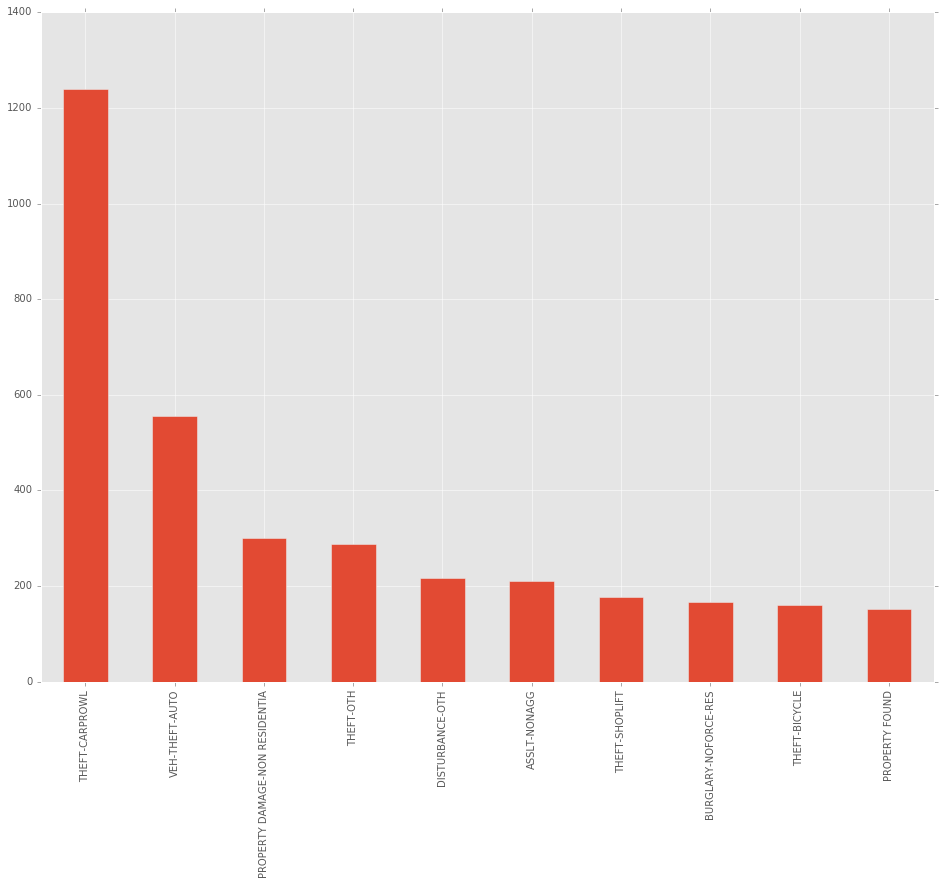

In [14]:
ei_series = pd.Series({ei[1]['Offense Type']: ei[1]['number_of_offenses'] for ei in evening_incidents.iterrows()})
ei_series.sort_values(ascending=False).head(10).plot.bar(figsize=(16,12))

By far the most common types of crime in the evening are `THEFT-CARPROWL` (which I'm interpreting as a call to the police to report someone prowling around a car) and `VEH-THEFT-AUTO`. Apparently, there are a lot of cars stolen during the evening hours in Seattle.

The next most common crimes are  `PROPERTY DAMAGE-NON RESIDENTIAL`, which I suspect is the code for vandalism, and `THEFT-OTH`. After that, `DISTURBANCE-OTH`, `ASSAULT-NONAGG`, `THEFT-SHOPLIFT`, `BURGLARY-NOFORCE-RES`, `THEFT-BICYCLE`, and `PROPERTY-FOUND` (which I believe is where the police receive a call to report someone finding lost property) round out the 10 most common types of incident.

#### Question 1.B) During what periods of the day are robberies most common?

I believe this question can be answered by repeating the basics of the area plot we used above, but restricting it just to those offenses coded as `ROBBERY-…`.

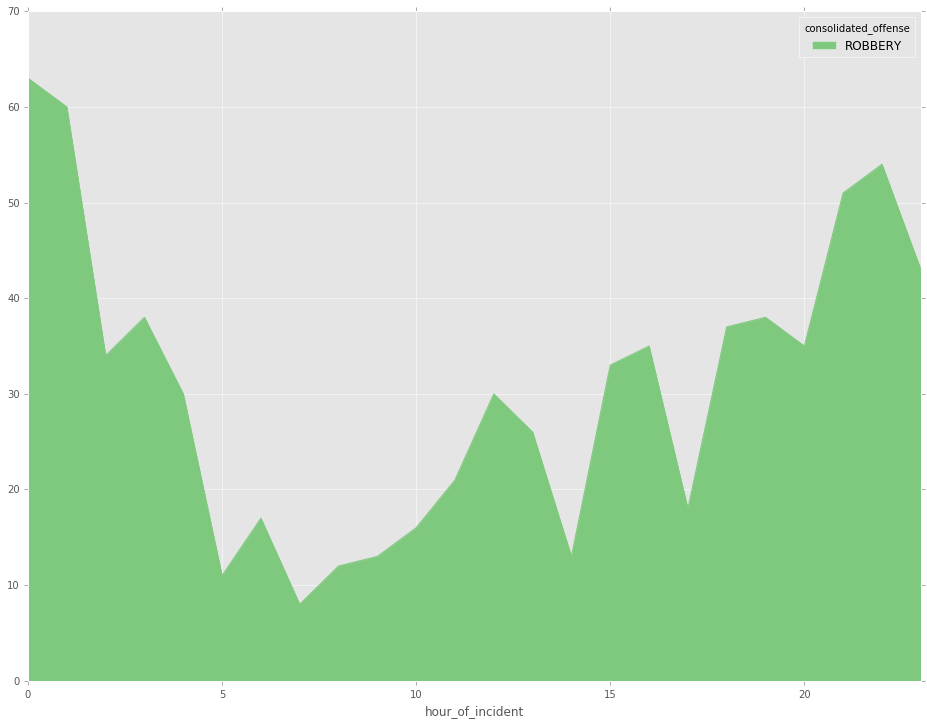

In [15]:
robberies_with_hour = (full_partly_consolidated_with_hour
    >> sift(X.consolidated_offense == 'ROBBERY')
)
hour_and_robberies = robberies_with_hour.pivot_table(
    index="hour_of_incident",  # We're going to use the date of the offense as the index.
    columns="consolidated_offense",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each date.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
hour_and_robberies.plot.area(figsize=(16,12), colormap='Accent')

This reveals that, much like crime in general, most robberies occur between noon and midnight, and especially between the hours of 6PM and midnight.